In [145]:
#IMPORT LIBRARIES
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig, PC_SHRED
import sys
import os
import pyshred
from Jakob_SHRED import Matser_utilz as utilz
from sklearn.preprocessing import MinMaxScaler
# from pyshred import PC_SHRED
# import seaborn as sns
# import sys
# from __future__ import print_function
# from IPython.display import clear_output as clc
# from tqdm import tqdm

# import cmcrameri.cm as cmc

# plt.style.use('default')


In [100]:
# DOMAIN DISCRETIZATION
def u_sol(t,x,n,Kn = 1,l = 1,c = 1):
        return Kn*np.sin(n*np.pi/l*(c*t))*np.sin(n*np.pi/l*x)
l = 1
c = 1
T = 2
N_t = 100
N_X = 200
t= np.linspace(0,T,N_t)
x = np.linspace(0,l,N_X)

def data_generate(n,t,x,l=1,c=1):
    data = np.zeros((len(t),len(x)))
    for i in range(len(t)):
        data[i,:] = u_sol(t[i],x,n =n,c=c, l = l)
    return data
data = data_generate(n=1,t=t,x=x)

In [142]:
lags = 0
x1 = 0.80
x2 = 0.05
x3 = 0.5
sensors = [np.argmin(x< x1),np.argmin(x< x2),np.argmin(x< x3)]

data_list = []
for n in range(1,10):
    if n != 5:
        
        data_list.append(data_generate(n=n,t=t,x=x))

# X_data, full_states = utilz.trajectory_gen(data_list,lags,sensors)
X_data, full_states = trajectory_gen(data_list,lags,sensors)

data_save = {
    'X':X_data,
    'y':full_states    
}

np.save('Wave_data/data_1.npy',data_save)

# # print(data[0:lags,sensors[0]])
# fig, ax = plt.subplots(1,2,figsize = (8,4))
# for j in range(len(sensors)):
#     ax[0].plot(data_list[0][:,sensors[j]])
#     ax[0].plot(X_data[:,j, 9],markersize = 10)
#     break


# ax[0].set_title('Sensor data and last input trajectory')
# ax[1].contourf(full_states)
# # ax[1].set_title('Target state at next time step')
# # ax[1].legend()
# plt.show()

# fig,ax = plt.subplots(figsize = (8,4))
# ax.contourf(x,t[lags:],full_states,100,cmap = 'jet')

-0.9998429784893453 0.9998429784893453
0.0 1.0
800


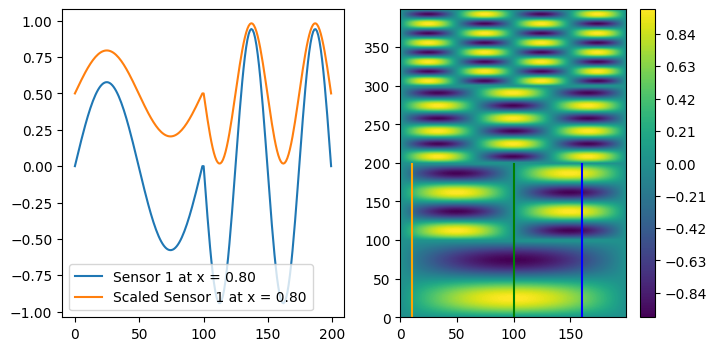

In [ ]:
def get_sensor_data(data_list, sensor_locations):
    t_dim = data_list[0].shape[0]
    N_systems = len(data_list)
    sensor_measurements_temp = np.zeros((t_dim, len(sensor_locations)))
    for n, data_temp in enumerate(data_list):
        for j, sensor in enumerate(sensor_locations):
            sensor_measurements_temp[:, j] = data_temp[:, sensor]
        if n < 1:
           sensor_measurements = sensor_measurements_temp.copy()
        else:
           sensor_measurements = np.vstack((sensor_measurements, sensor_measurements_temp))
    return sensor_measurements



sensor_meas = get_sensor_data(data_list, sensors)
sc = MinMaxScaler()
sc.fit(sensor_meas)
sensor_meas_new = sc.transform(sensor_meas)



print(sensor_meas.min(), sensor_meas.max())
print(sensor_meas_new.min(), sensor_meas_new.max())
print(len(data_list)*N_t)

fig, ax = plt.subplots(1,2,figsize = (8,4))
for j in range(len(sensors)):
    ax[0].plot(sensor_meas[:200,j],label = f'Sensor {j+1} at x = {x[sensors[j]]:.2f}')
    ax[0].plot(sensor_meas_new[:200,j],label = f'Scaled Sensor {j+1} at x = {x[sensors[j]]:.2f}')
    break
ax[0].legend()
# ax[0].set_title('Sensor data')
cf1 = ax[1].contourf(full_states[0:400,:],levels = 200)
# ax[1].plot((sensors[0],sensors[0]),(0,199))
ax[1].plot()
colorbar = fig.colorbar(cf1, ax=ax[1])
ax[1].plot((sensors[0],sensors[0]),(0,199), color = 'blue')
ax[1].plot((sensors[1],sensors[1]),(0,199), color = 'orange')
ax[1].plot((sensors[2],sensors[2]),(0,199), color = 'green')
plt.show()
# fig, ax = plt.subplots(figsize = (8,4))
# # for i in range(len(data_list)):
# #     ax.plot(data_list[i][:,sensors[0]])
# ax.plot(full_states[98,:])
# ax.plot(full_states[98+99,:])
# ax.plot(full_states[98+2*99,:])
# ax.plot(full_states[98+3*99,:])
# plt.show()

In [76]:
print(data_list[0].shape)

(100, 200)


In [4]:
class SHREDdataLoader(torch.utils.data.Dataset):
    """
    PyTorch Dataset for time series sensor data and corresponding full-state measurements.

    Parameters
    ----------
    X : torch.Tensor
        Input sensor sequences of shape (batch_size, lags, num_sensors).
    Y : torch.Tensor
        Target full-state measurements of shape (batch_size, state_dim).

    Attributes
    ----------
    X : torch.Tensor
        Sensor measurement sequences.
    Y : torch.Tensor
        Full-state target measurements.
    len : int
        Number of samples in the dataset.
    """
    
    def __init__(self, DATA):
        """
        Initialize the TimeSeriesDataset.

        Parameters
        ----------
        X : torch.Tensor
            Input sensor sequences of shape (batch_size, lags, num_sensors).
        Y : torch.Tensor
            Target full-state measurements of shape (batch_size, state_dim).
        """
        self.X = DATA['X']
        self.Y = DATA['y']
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        """
        Get a single sample from the dataset.

        Parameters
        ----------
        index : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple
            (sensor_sequence, target_state) pair.
        """
        return self.X[index], self.Y[index]

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns
        -------
        int
            Number of samples.
        """
        return self.len
    def split_data(self,train_ratio = 0.8,val_ratio = 0.1,test_ratio = 0.1,seed = 42):
        generator = torch.Generator().manual_seed(seed)
        train, val, test = random_split(self, [train_ratio, val_ratio, test_ratio], generator=generator)
        
        train_data = {
            'X':self.X[train.indices],
            'y':self.Y[train.indices]
        }
        val_data = {
            'X':self.X[val.indices],
            'y':self.Y[val.indices]
        }
        test_data = {
            'X':self.X[test.indices],
            'y':self.Y[test.indices]
        }

        train_dataset = SHREDdata(train_data)
        val_dataset = SHREDdata(val_data)
        test_dataset = SHREDdata(test_data)

        return train_dataset,val_dataset,test_dataset
class SHREDdata(torch.utils.data.Dataset):
    """
    PyTorch Dataset for time series sensor data and corresponding full-state measurements.

    Parameters
    ----------
    X : torch.Tensor
        Input sensor sequences of shape (batch_size, lags, num_sensors).
    Y : torch.Tensor
        Target full-state measurements of shape (batch_size, state_dim).

    Attributes
    ----------
    X : torch.Tensor
        Sensor measurement sequences.
    Y : torch.Tensor
        Full-state target measurements.
    len : int
        Number of samples in the dataset.
    """
    
    def __init__(self, DATA):
        """
        Initialize the TimeSeriesDataset.

        Parameters
        ----------
        X : torch.Tensor
            Input sensor sequences of shape (batch_size, lags, num_sensors).
        Y : torch.Tensor
            Target full-state measurements of shape (batch_size, state_dim).
        """
        self.X = DATA['X']
        self.Y = DATA['y']
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        """
        Get a single sample from the dataset.

        Parameters
        ----------
        index : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple
            (sensor_sequence, target_state) pair.
        """
        return self.X[index], self.Y[index]

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns
        -------
        int
            Number of samples.
        """
        return self.len
    
    
    def split_data(self,train_ratio = 0.8,val_ratio = 0.1,test_ratio = 0.1,seed = 42):
        generator = torch.Generator().manual_seed(seed)
        train, val, test = random_split(self, [train_ratio, val_ratio, test_ratio], generator=generator)

        train_data = {
            'X':self.X[train.indices],
            'y':self.Y[train.indices]
        }
        val_data = {
            'X':self.X[val.indices],
            'y':self.Y[val.indices]
        }
        test_data = {
            'X':self.X[test.indices],
            'y':self.Y[test.indices]
        }


        train_dataset = SHREDdata(train_data)
        val_dataset = SHREDdata(val_data)
        test_dataset = SHREDdata(test_data)

        return train_dataset,val_dataset,test_dataset
        

In [35]:
manager = DataManager(
    lags=5,          # 
    train_size=0.8,   # 80% for training We take 80% from the start 0,1,2,3... 
    val_size=0.1,     # 10% for validation Then comes val 10% from where train ends.
    test_size=0.1     # 10% for testing Lastly comes test.

)
x1 = 0.60
x2 = 0.05
x3 = 0.5
# data = np.load('Wave_data/data_1.npy',allow_pickle=True).item()
sensor_locs = [np.argmin(x< x1),np.argmin(x< x2),np.argmin(x< x3)]
manager.add_data(
    data=data,         # Must have time as the first index of the data. 
    id="burger",          # Unique identifier for the dataset
    # random=10,          # Randomly select 3 sensor locations
    stationary = [(sensor_locs[0],),(sensor_locs[1],),(sensor_locs[2],)],
    compress=False     # Keep original spatial resolution (no compression)
)
from sklearn.preprocessing import MinMaxScaler
scaler_test = MinMaxScaler()
print(manager.sensor_measurements[manager.train_indices].shape)
scaler_test.fit(manager.sensor_measurements[manager.train_indices])
print(scaler_test.transform(manager.sensor_measurements[manager.train_indices]).max())
# manager.sensor_measurements[manager.train_indices][10]

(160, 3)
1.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = np.load('Wave_data/data_1.npy',allow_pickle=True).item()

# data['X'] = torch.tensor(data['X'],dtype = torch.float32,device = device)
# data['y'] = torch.tensor(data['y'],dtype = torch.float32,device = device)

generator = torch.Generator().manual_seed(42)
data_all = utilz.SHREDdata(data)

train_dataset, val_dataset, test_dataset = data_all.split_data(train_ratio = 0.8, val_ratio=0.1, test_ratio=0.1, seed=42)



# scaler = data_all.data_scaler(train_dataset)
print(train_dataset.X.shape)

# train_dataset = scaler.transform(train_dataset)
# val_dataset = scaler.transform(val_dataset)




(2650, 3, 16)


In [6]:
pc_shred = PC_SHRED(sequence_model="LSTM",
    decoder_model="MLP")

#move train data to device
# train_data = train_data.to(DeviceConfig.device)

val_errors = pc_shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=40,
    batch_size= 128,
    verbose = True,
    lr = 0.0004,
    patience = 100
)

Fitting SHRED...
Epoch 1: Average training loss = 0.250087
Validation MSE (epoch 1): 0.000005
Epoch 2: Average training loss = 0.248954
Validation MSE (epoch 2): 0.000005
Epoch 3: Average training loss = 0.244141
Validation MSE (epoch 3): 0.000005
Epoch 4: Average training loss = 0.234020
Validation MSE (epoch 4): 0.000005
Epoch 5: Average training loss = 0.224390
Validation MSE (epoch 5): 0.000004
Epoch 6: Average training loss = 0.213356
Validation MSE (epoch 6): 0.000004
Epoch 7: Average training loss = 0.204807
Validation MSE (epoch 7): 0.000004
Epoch 8: Average training loss = 0.197074
Validation MSE (epoch 8): 0.000004
Epoch 9: Average training loss = 0.189393
Validation MSE (epoch 9): 0.000004
Epoch 10: Average training loss = 0.180882
Validation MSE (epoch 10): 0.000004
Epoch 11: Average training loss = 0.171678
Validation MSE (epoch 11): 0.000003
Epoch 12: Average training loss = 0.162479
Validation MSE (epoch 12): 0.000003
Epoch 13: Average training loss = 0.153675
Validation

In [7]:
test123 = pc_shred._seq_model_outputs(val_dataset.X)

pred = pc_shred.decoder(test123)

test1 = pc_shred.forward(val_dataset.X)

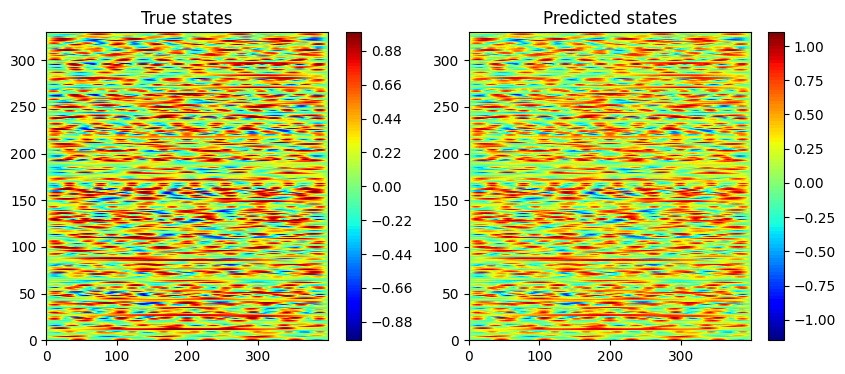

In [8]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
cf1 = ax[0].contourf(val_dataset.Y.detach().cpu(),100,cmap = 'jet')
cf2 = ax[1].contourf(test1.detach().cpu(),100,cmap = 'jet')

ax[0].set_title('True states')
ax[1].set_title('Predicted states')
colorbar1 = fig.colorbar(cf1, ax=ax[0])
colorbar2 = fig.colorbar(cf2, ax=ax[1])


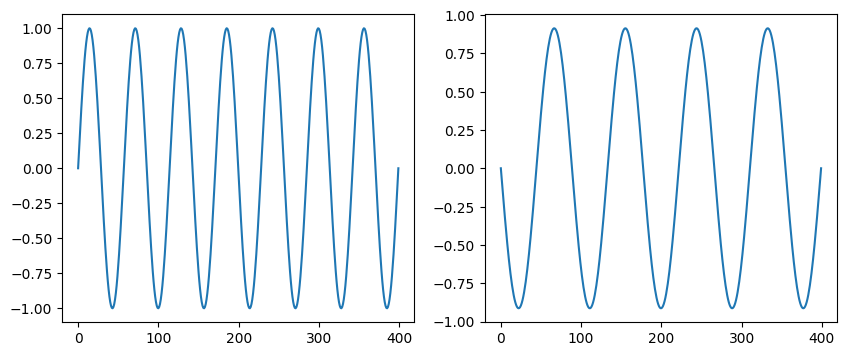

In [27]:
test_index = 1
fig, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].plot(train_dataset.Y.detach().cpu()[test_index])
ax[1].plot(train_dataset.Y.detach().cpu()[test_index*2])

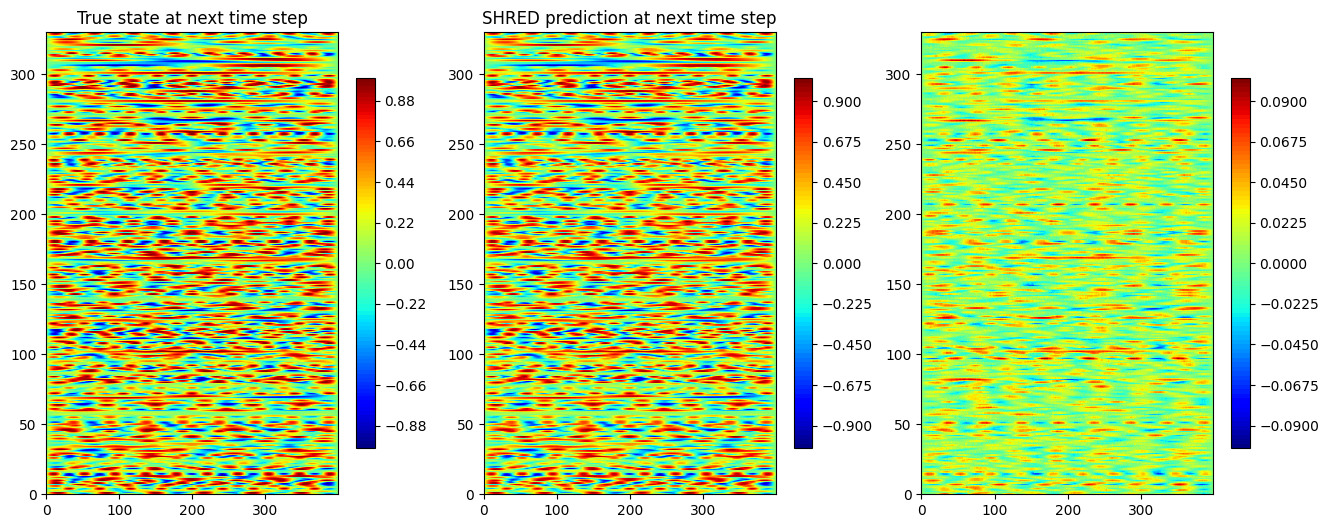

In [8]:
manager = DataManager(
    lags = 50,
    train_size= 0.8,
    val_size = 0.1,
    test_size = 0.1    
)

engine = SHREDEngine(manager, shred)

# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.model._seq_model_outputs(test_dataset.X, sindy=False)
# print(test_dataset.X)
# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.model.decoder(test_latent_from_sensors)

fig, ax = plt.subplots(1,3,figsize = (16,6))
cf1 = ax[0].contourf(test_dataset.Y.cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf1, ax=ax[0],shrink=0.8)
ax[0].set_title('True state at next time step')
cf2 = ax[1].contourf(test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf2, ax=ax[1],shrink=0.8)
ax[1].set_title('SHRED prediction at next time step')
cf3 = ax[2].contourf(test_dataset.Y.cpu().numpy()-test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf3, ax=ax[2],shrink=0.8)
# test_latent_from_sensors = engine.sensor_to_latent(test_dataset.X)

In [ ]:
def u_sol(t,x,n,Kn = 1,l = 1,c = 1):
        return Kn*np.sin(n*np.pi/l*(c*t))*np.sin(n*np.pi/l*x)
l = 1
c = 1
T = 4
N_t = 200
N_X = 400
lags = 16
t= np.linspace(0,T,N_t)
x = np.linspace(0,l,N_X)
def data_generate(n,t,x,l=1,c=1):
    data = np.zeros((len(t),len(x)))
    for i in range(len(t)):
        data[i,:] = u_sol(t[i],x,n =3,Kn = 1, c=1)
    return data

extra_test = [data_generate(n=4,t=t,x=x)]
X_data, full_states = utilz.trajectory_gen(extra_test,lags,sensors)
data_save1 = {
    'X':X_data,
    'y':full_states    
}

np.save('Wave_data/data_1_test.npy',data_save1)

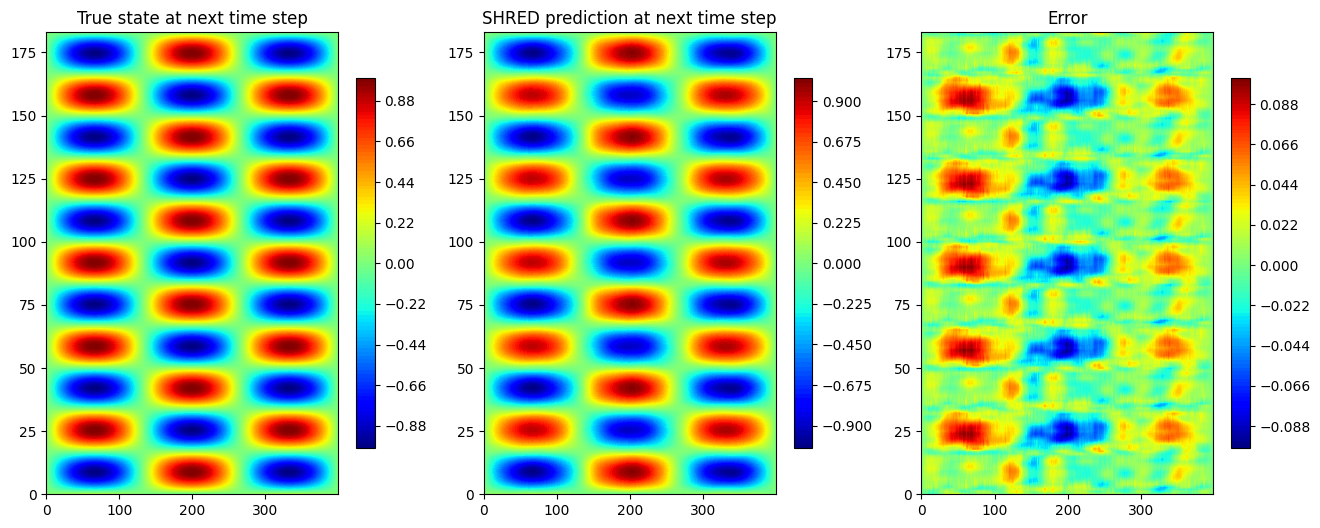

In [54]:
data_verify = np.load('Wave_data/data_1_test.npy',allow_pickle=True).item()

data_verify['X'] = torch.tensor(data_verify['X'],dtype = torch.float32,device = device)
data_verify['y'] = torch.tensor(data_verify['y'],dtype = torch.float32,device = device)

test_latent_from_sensors = engine.model._seq_model_outputs(data_verify['X'], sindy=False)

test_reconstruction = engine.model.decoder(test_latent_from_sensors)

fig, ax = plt.subplots(1,3,figsize = (16,6))
cf1 = ax[0].contourf(data_verify['y'].cpu().numpy(), 100,cmap = 'jet')
plt.colorbar(cf1, ax=ax[0],shrink=0.8) 
ax[0].set_title('True state at next time step')
cf2 = ax[1].contourf(test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf2, ax=ax[1],shrink=0.8)
ax[1].set_title('SHRED prediction at next time step')
cf3 = ax[2].contourf(data_verify['y'].cpu().numpy()-test_reconstruction.detach().cpu().numpy(),100,cmap = 'jet')
plt.colorbar(cf3, ax=ax[2],shrink=0.8)                      
ax[2].set_title('Error')
plt.show()

